1. Generate blended imaged
2. Code to take feedback and generate confidence scores

https://github.com/IlliaOvcharenko/lung-segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Projects/Pulsar-AI/Code/lung-segmentation-master')

In [ ]:
import torch
import torchvision
import glob
import time
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice
import torch.nn.functional as F

In [ ]:
from tqdm import tqdm
import torchvision.transforms as T

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import pdb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data loading

## Inference


In [ ]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2,
    batch_norm=True,
    upscale_mode="bilinear"
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 169MB/s]


In [ ]:
model_name = "unet-model1.pt"
unet.load_state_dict(torch.load("/content/drive/MyDrive/Projects/Pulsar-AI/saved_models/model1.pt", map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [ ]:
device

device(type='cuda', index=0)

## Test inference on random image

In [ ]:
from google.colab import output
from IPython.display import clear_output

shape =  torch.Size([1, 2, 256, 256])
mean = tensor(0.9694)
% softmax_thresh =  tensor(0.9402)
% softmax_thresh1 =  tensor(0.9031)


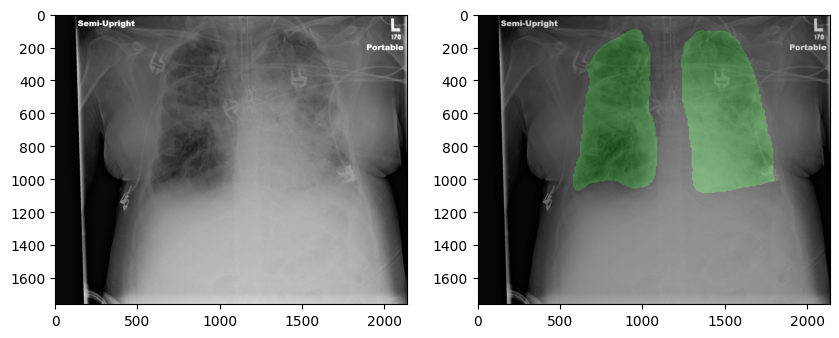

KeyboardInterrupt: ignored

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/MontgomerySet/CXR_png" # read from UPMC ARDS in VeyTel database

arr = os.listdir(image_dir)

for image_name in arr:
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  origin1 = Image.open(image_path)
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      inp = input('show next image? \n')
      clear_output()
      print("shape = ",softmax.shape)
      softmax1 = torch.exp(softmax)
      softmax1_max = torch.max(softmax1, 1)[0]
      print("mean =",torch.mean(softmax1_max))
      softmax_thresh = torch.sum(softmax1_max>0.8)
      softmax_thresh1 = torch.sum(softmax1_max>0.9)
      print("% softmax_thresh = ",softmax_thresh/(256*256))
      print("% softmax_thresh1 = ",softmax_thresh1/(256*256))
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      out_reshape = torch.permute(out_upsample,(1,2,0))
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
  plt.figure(figsize=(15,9))
  plt.subplot(1, 2, 1)
  plt.imshow(origin_reshape)
  plt.subplot(1, 2, 2)
  plt.imshow(origin_blend)
  plt.imsave("")
  plt.show()



# Inference from Individual Folders of UPMC data

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ARDS" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  origin1 = Image.open(image_path).convert("RGB")
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      out_reshape = torch.permute(out_upsample,(1,2,0))
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
      origin_blend.save(save_path)

new save directory created for lung segmentation


100%|██████████| 492/492 [25:01<00:00,  3.05s/it]


## Check size and format

In [ ]:
image_blend = Image.open('/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ARDS/04238_170815.png')
print(image_blend.format)
print(image_blend.size)
print(image_blend.mode)

PNG
(2020, 2021)
RGB


In [ ]:
image_cxr = Image.open('/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS/04238_170815.png')
print(image_cxr.format)
print(image_cxr.size)
print(image_cxr.mode)

PNG
(2020, 2021)
RGB


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ARDS" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ARDS" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

492
492


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ProCopi-V2.1.0-V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ProCopi-V2.1.0-V2.1.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)
for image_name in tqdm(arr):
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  # print("shape of origin =",origin.shape)
  origin1 = Image.open(image_path).convert("RGB")
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  # print("shape of origin1 =",origin1.shape)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      # print("shape of out_upsample =",out_upsample.shape)
      out_reshape = torch.permute(out_upsample,(1,2,0))
      # print("shape of out_reshape =",out_reshape.shape)
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      # print("shape of out_reshape1 =",out_reshape1.shape)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
      origin_blend.save(save_path)


new save directory created for resized lung segmentation


100%|██████████| 144/144 [07:55<00:00,  3.31s/it]


In [ ]:
image_blend = Image.open('/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ProCopi-V2.1.0-V2.1.3/10149_201220.png')
print(image_blend.format)
print(image_blend.size)
print(image_blend.mode)
image_cxr = Image.open('/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ProCopi-V2.1.0-V2.1.3/10149_201220.png')
print(image_cxr.format)
print(image_cxr.size)
print(image_cxr.mode)

PNG
(1294, 1158)
RGB
PNG
(1294, 1158)
RGBA


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC-ProCopi-V2.1.0-V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC-ProCopi-V2.1.0-V2.1.3" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

144
144


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ALIR_V2.0.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
    file_extension = os.path.splitext(image_name)[1]
    # Check if file extension is ".png"
    if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)

new save directory created for resized lung segmentation


100%|██████████| 98/98 [14:21<00:00,  8.79s/it]


In [ ]:
image_blend = Image.open('/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ALIR_V2.0.1/05091_200329.png')
print(image_blend.format)
print(image_blend.size)
print(image_blend.mode)
image_cxr = Image.open('/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1/05091_200329.png')
print(image_cxr.format)
print(image_cxr.size)
print(image_cxr.mode)

PNG
(1780, 2020)
RGB
PNG
(1780, 2020)
RGB


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ALIR_V2.0.1" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr)) #two folder and one txt
print((len(arr1)))

98
95


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ALIR_V2.0.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 63/63 [04:59<00:00,  4.76s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ALIR_V2.0.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ALIR_V2.0.2" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

63
63


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)


new save directory created for resized lung segmentation


100%|██████████| 116/116 [05:59<00:00,  3.10s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.1" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

116
116


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 115/115 [05:45<00:00,  3.01s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.2" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

115
115


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 117/117 [05:45<00:00,  2.95s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.3" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

117
117


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.4" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 112/112 [05:43<00:00,  3.07s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ARDS_V2.2.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ARDS_V2.2.4" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

112
112


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_Floor_V2.1.4" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 98/98 [09:51<00:00,  6.04s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.4" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_Floor_V2.1.4" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

98
98


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.5" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_Floor_V2.1.5" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 41/41 [03:20<00:00,  4.88s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_Floor_V2.1.5" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_Floor_V2.1.5" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

41
41


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi2/Images" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 159/159 [04:00<00:00,  1.51s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi2/Images" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi2" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

159
159


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.0" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.0" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 25/25 [01:03<00:00,  2.55s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.0" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.0" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

25
25


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.1" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)


for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.1" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.1" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

25
25


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.2" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 47/47 [01:51<00:00,  2.38s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.2" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.2" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

47
47


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.3" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 47/47 [01:56<00:00,  2.48s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.3" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.3" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

47
47


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.6" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.6" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  if file_extension == ".png":
    image_path = os.path.join(image_dir, image_name)
    origin = Image.open(image_path).convert("L")
    origin = torchvision.transforms.functional.resize(origin, (256, 256))
    origin = torchvision.transforms.functional.to_tensor(origin)
    origin1 = Image.open(image_path).convert("RGB")
    origin1 = torchvision.transforms.functional.to_tensor(origin1)
    height = origin1.shape[1]
    width = origin1.shape[2]

    with torch.no_grad():
        origin = torch.stack([origin])
        origin = origin.to(device)
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)
        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
        threshold = 0.5
        out_upsample = (out_upsample > threshold).float()
        out_reshape = torch.permute(out_upsample,(1,2,0))
        out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
        origin_reshape = torch.permute(origin1,(1,2,0))
        segmented_lung = out_reshape1 * origin_reshape

        transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
        origin_blend = transform(origin_reshape.permute(2,0,1))
        out_reshape1[:,:,0] = 0
        out_reshape1[:,:,2] = 0
        mask_blend = transform(out_reshape1.permute(2,0,1))
        origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
        save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
        origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 159/159 [04:01<00:00,  1.52s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/UPMC_ProCopi_V2.1.6" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/UPMC_ProCopi_V2.1.6" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

159
159


## Cleaveland clinic images

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID"
arr = os.listdir(image_dir)
print(len(arr))

1117


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/CCF_COVID" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for resized lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  file_extension = os.path.splitext(image_name)[1]
  # Check if file extension is ".png"
  #if file_extension == ".png":
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  origin1 = Image.open(image_path).convert("RGB")
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      out_reshape = torch.permute(out_upsample,(1,2,0))
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
      origin_blend.save(save_path)



new save directory created for resized lung segmentation


100%|██████████| 1117/1117 [25:19<00:00,  1.36s/it]


In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/CCF_COVID" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/CCF_COVID" # write to lung folder
arr = os.listdir(image_dir)
arr1 = os.listdir(save_dir_lung)
print(len(arr))
print((len(arr1)))

1117
1117


## Montgomery Inference

In [ ]:
image_dir = "/content/drive/Shareddrives/PulSAR-AI/Images/MontgomerySet/CXR_png" # read from UPMC ARDS in VeyTel database
save_dir_lung = "/content/drive/MyDrive/Projects/Pulsar-AI/segmented_CXR/lung_blend/MontgomerySet" # write to lung folder
isExist_lung = os.path.exists(save_dir_lung)
if not isExist_lung:
   # Create a new directory if it does not exist
   os.makedirs(save_dir_lung)
   print("new save directory created for lung segmentation")
arr = os.listdir(image_dir)

for image_name in tqdm(arr):
  image_path = os.path.join(image_dir, image_name)
  origin = Image.open(image_path).convert("L")
  origin = torchvision.transforms.functional.resize(origin, (256, 256))
  origin = torchvision.transforms.functional.to_tensor(origin)
  origin1 = Image.open(image_path).convert("RGB")
  origin1 = torchvision.transforms.functional.to_tensor(origin1)
  height = origin1.shape[1]
  width = origin1.shape[2]

  with torch.no_grad():
      origin = torch.stack([origin])
      origin = origin.to(device)
      out = unet(origin)
      softmax = torch.nn.functional.log_softmax(out, dim=1)
      out = torch.argmax(softmax, dim=1)
      origin = origin[0].to("cpu")
      out = out[0].to("cpu")
      out_upsample = torch.squeeze(F.interpolate(out.float().unsqueeze(0).unsqueeze(0), size = [height,width], mode='bilinear'), dim = 0)
      threshold = 0.5
      out_upsample = (out_upsample > threshold).float()
      out_reshape = torch.permute(out_upsample,(1,2,0))
      out_reshape1 = torch.repeat_interleave(out_reshape, 3, dim=2)
      origin_reshape = torch.permute(origin1,(1,2,0))
      segmented_lung = out_reshape1 * origin_reshape

      transform = T.ToPILImage() # transform to convert tensor to PIL image to do blending
      origin_blend = transform(origin_reshape.permute(2,0,1))
      out_reshape1[:,:,0] = 0
      out_reshape1[:,:,2] = 0
      mask_blend = transform(out_reshape1.permute(2,0,1))
      origin_blend = Image.blend(origin_blend, mask_blend, 0.2) #blend the CXR with the mask
      save_path = os.path.join(save_dir_lung, image_name) # get the path from the dir + image name
      origin_blend.save(save_path)

 16%|█▌        | 22/139 [02:22<12:35,  6.46s/it]


KeyboardInterrupt: ignored